In [1]:
import os
import sys
project_name = 'ai_synth'
src_dir_relative_path = '../../../src'
if src_dir_relative_path not in sys.path:
    sys.path.append(src_dir_relative_path)

from pathlib import Path
from torchaudio.transforms import Spectrogram, AmplitudeToDB
from model.loss import spectral_loss
from synth.synth_architecture import SynthModular
from main_hp_search_dec_only import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants
from utils.visualization_utils import  calc_loss_vs_param_range, plot_loss_vs_param
from utils.train_utils import to_torch_recursive

import matplotlib
matplotlib.pyplot.ion()

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

notebook_path = Path('.').resolve()
dir_list = notebook_path.parts
root_index = dir_list.index(project_name)
abs_path = Path(*dir_list[:root_index+1])

project_root = abs_path

In [2]:
# Setup experiment

exp_name = 'loss_surface_visualization_osc_adsr'
dataset_name = 'osc_adsr_single'
device = 'cpu'

config_path = os.path.join(project_root, 'configs', 'optimization_analysis', 'osc_adsr_single_synth_config_hp_search.yaml')
data_path = os.path.join(project_root, 'data', dataset_name, 'train', '')

cfg = configure_experiment(exp_name, dataset_name, config_path, debug=True)

synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

dataset = AiSynthDataset(data_path, noise_std=0)

Deleting previous experiment...


In [3]:
target_sample = dataset[0]
target_signal, target_param_dict, signal_index = target_sample

target_param_dict = to_torch_recursive(target_param_dict, device, ignore_dtypes=(str, tuple))

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(0, 0): {'operation': 'osc', 'parameters': {'active': tensor([True]), 'amp': tensor([0.5434]), 'freq': tensor([174.6141]), 'waveform': 'square'}}, (0, 1): {'operation': 'env_adsr', 'parameters': {'attack_t': tensor([0.2373]), 'decay_t': tensor([0.2438]), 'sustain_t': tensor([0.2689]), 'sustain_level': tensor([0.2695]), 'release_t': tensor([0.0470])}}}


In [4]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants,
                                          device=device)

In [5]:
params_to_visualize = [{'param_name': 'amp', 'cell_index': (0, 0), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       {'param_name': 'freq', 'cell_index': (0, 0), 'min_val': 0, 'max_val': 2000, 'n_steps': 2000},
                       {'param_name': 'attack_t', 'cell_index': (0, 1), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       {'param_name': 'decay_t', 'cell_index': (0, 1), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       {'param_name': 'sustain_t', 'cell_index': (0, 1), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       {'param_name': 'sustain_level', 'cell_index': (0, 1), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       {'param_name': 'release_t', 'cell_index': (0, 1), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       ]


In [ ]:
import numpy as np
from scipy.signal import argrelmin

def get_num_of_local_min(x):
    x = np.array(x)
    # Find the indices of the local minima
    indices = argrelmin(x)[0]
    num_minima = len(indices)

    print("Number of local minima:", num_minima)
    return num_minima

In [8]:
for param_to_visualize in params_to_visualize:
    loss_vals, param_range = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler, **param_to_visualize)
    plot_loss_vs_param(param_range, loss_vals, title=f'Loss vs {param_to_visualize["param_name"]}')
    get_num_of_local_min(loss_vals)

 52%|█████▏    | 518/1000 [00:05<00:04, 99.55it/s] 


KeyboardInterrupt: 

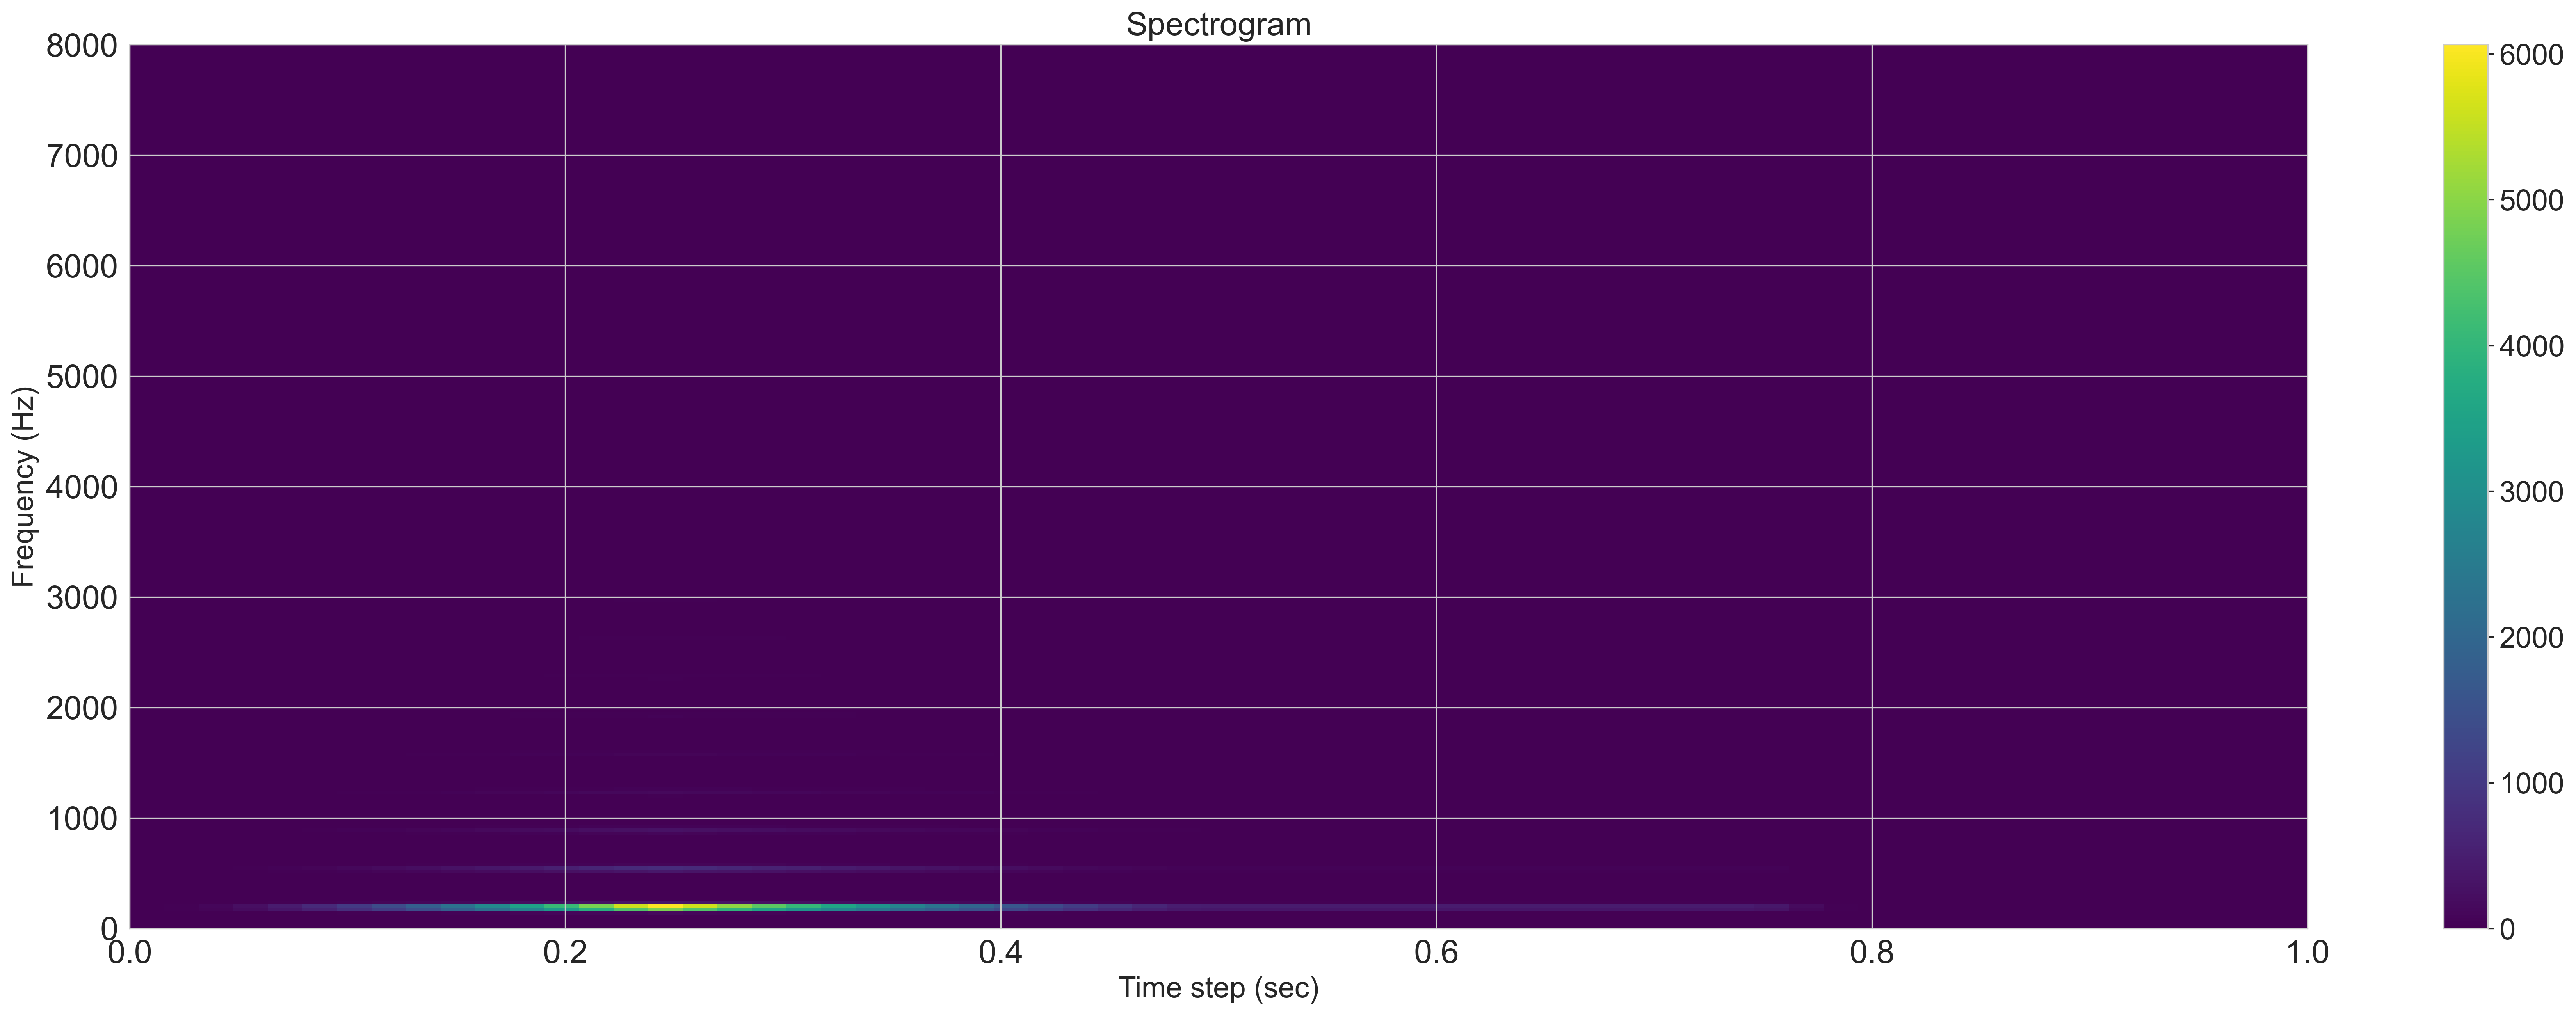

In [7]:

sample_rate = 16000
n_fft = 512
spec_op = Spectrogram(n_fft=n_fft, power=2.0, pad_mode='reflect')
db = AmplitudeToDB()

plt.figure(figsize=(30, 10))
plt.gcf().set_dpi(300)
target_spec = spec_op(target_signal.cpu())

plt.imshow(target_spec.squeeze(), origin='lower', aspect='auto', cmap='viridis', extent=[0, 1, 0, sample_rate/2])

plt.title('Spectrogram', fontsize=20)
plt.ylabel('Frequency (Hz)', fontsize=18)
plt.xlabel('Time step (sec)', fontsize=18)
plt.tick_params(labelsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)

plt.show()
